# Stimulated 40h Data pre-processing and Basic Analysis 


In [1]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io
from kneed import KneeLocator
from gprofiler import GProfiler

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

In [2]:
# load data
adata = sc.read_h5ad('stimulated_40h.h5ad')
adata

/Users/Sian/anaconda3/lib/python3.10/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/Sian/anaconda3/lib/python3.10/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 146433 × 1371
    obs: 'X10X_operator', 'Age', 'Cell_culture_batch', 'Cell_state', 'Cell_type', 'Donor', 'Medications', 'Plate', 'Sample_description', 'Sample_id', 'Sex', 'Time_point', 'Well', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'Deconvolution_status', 'cellranger_status', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'S_score', 'G2M_score', 'Phase', 'Activation_level', 'Size_Factor', 'Activation_pseudotime', 'Cell_population', 'Cluster_id'
    var: 'gene_ids', 'feature_types', 'chr', 'start', 'end', 'strand', 'biotype', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_population_colors', 'Cell_state_colors', 'cellranger_

In [3]:
#  Map Ensembl gene IDs to gene symbols


def map_ensembl_to_symbol(ensembl_ids):
    gp = GProfiler(return_dataframe=True)
    annotations = gp.convert(organism='hsapiens', query=ensembl_ids)
    mapping = annotations.set_index("incoming").to_dict()["name"]
    return mapping

# Extract Ensembl gene IDs from your AnnData object
ensembl_ids = adata.var["gene_ids"].tolist()

# Get the mapping
id_to_symbol_mapping = map_ensembl_to_symbol(ensembl_ids)

# Add gene symbols to the AnnData object
adata.var["gene_symbols"] = adata.var["gene_ids"].map(id_to_symbol_mapping)


In [4]:
print(adata.var.gene_symbols)

index
PLEKHN1          PLEKHN1
ISG15              ISG15
TNFRSF18        TNFRSF18
TNFRSF4          TNFRSF4
AL691432.2          None
                 ...    
LINC01678      LINC01678
POFUT2            POFUT2
MCM3AP-AS1    MCM3AP-AS1
MT-ND4L          MT-ND4L
MT-ND5            MT-ND5
Name: gene_symbols, Length: 1371, dtype: object


In [5]:
# set the index in var to feature_name which is the geneid
adata.var.index = adata.var["gene_symbols"]

# Basic QC

### Perform singular value decomposition

#### Represent the cells in 2D with PCA

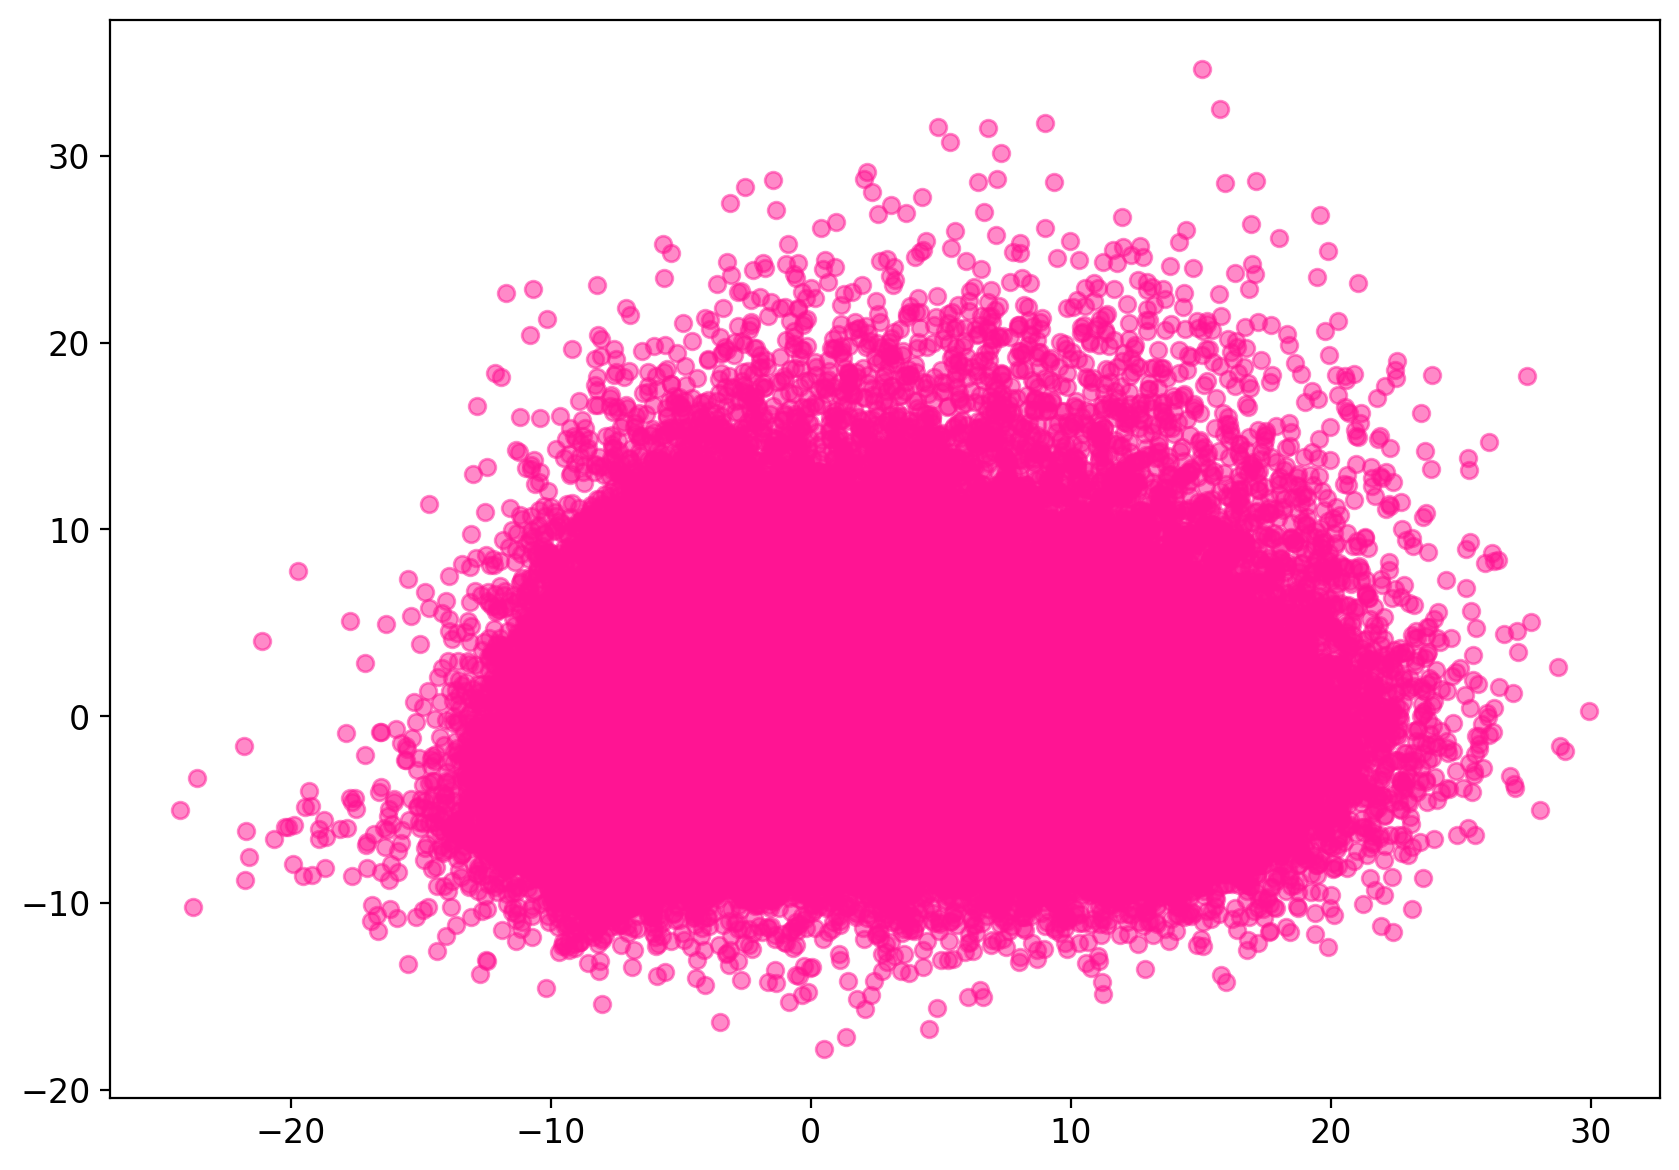

In [6]:
# Perform TruncatedSVD
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c = 'deeppink')  


plt.axis('on')
plt.show()

## Test for library saturation
##### For each cell we ask how many genes did we detect (or see non-zero expression). If we have "saturated" our sequencing library then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis). 
##### using the flatten() method to ensure that the result is a 1-dimensional array, which can help in some cases where the result might otherwise be an array with one of its dimensions equal to 1 (e.g., shape like (n, 1)).

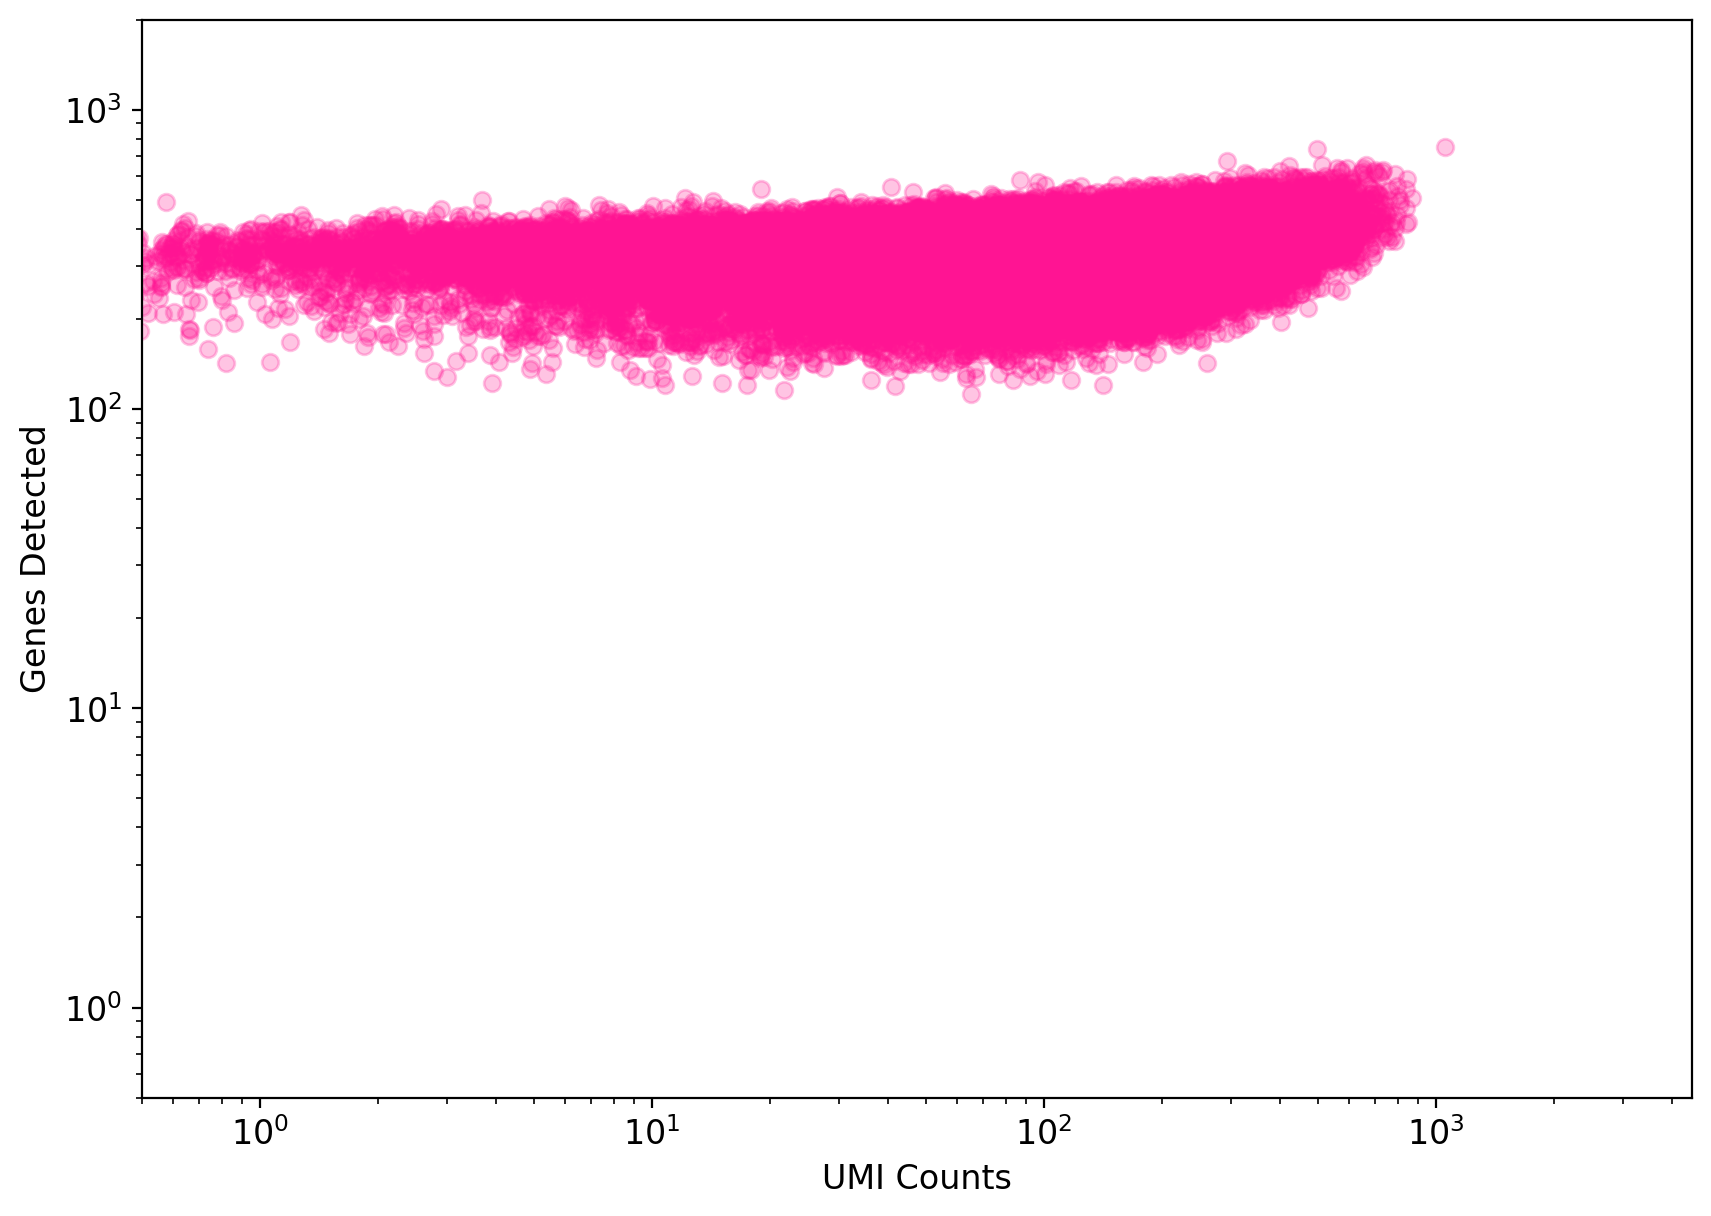

In [7]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1)).flatten()
y = np.asarray(np.sum(adata.X>0, axis=1)).flatten()

ax.scatter(x, y, color="deeppink", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

###  Looking at the knee plot
##### cells are ordered by the number of UMI counts associated to them (shown on the x-axis), and the fraction of droplets with at least that number of cells is shown on the y-axis. The idea is that "real" cells have a certain number of UMI counts and that a threshold on the UMI counts filters those cells.

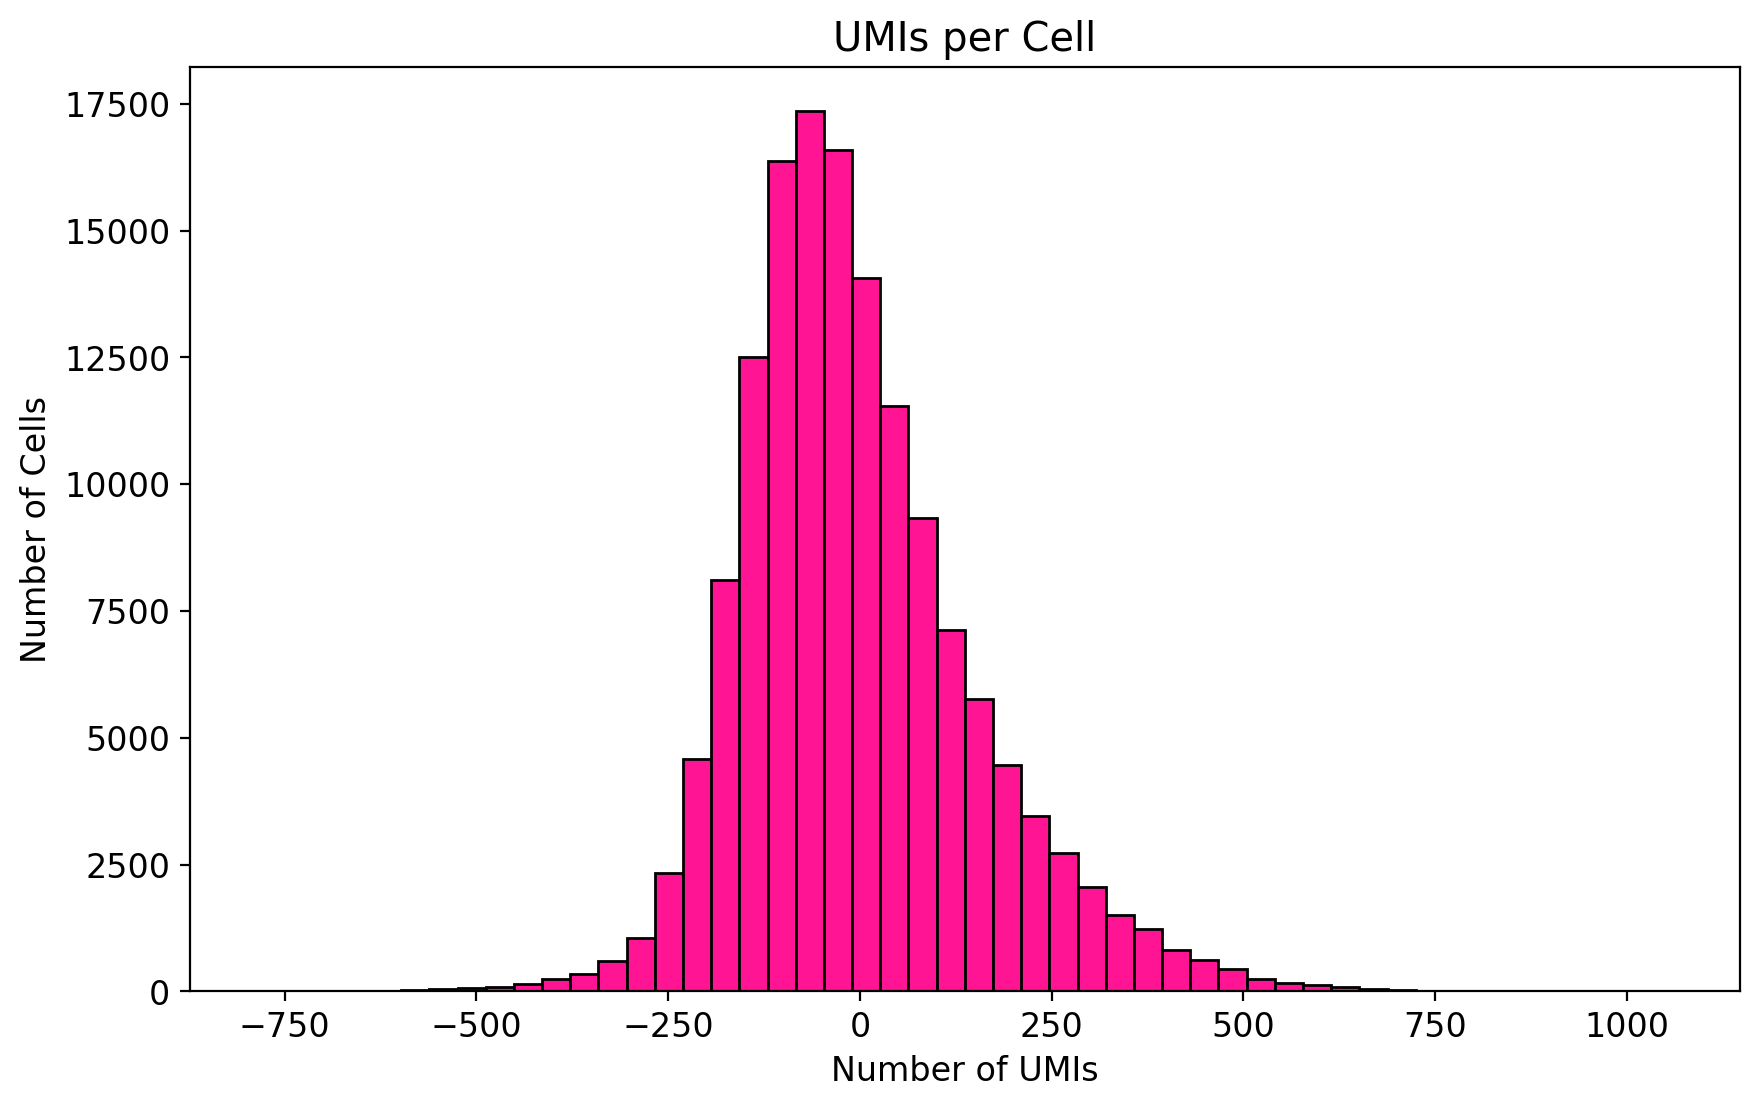

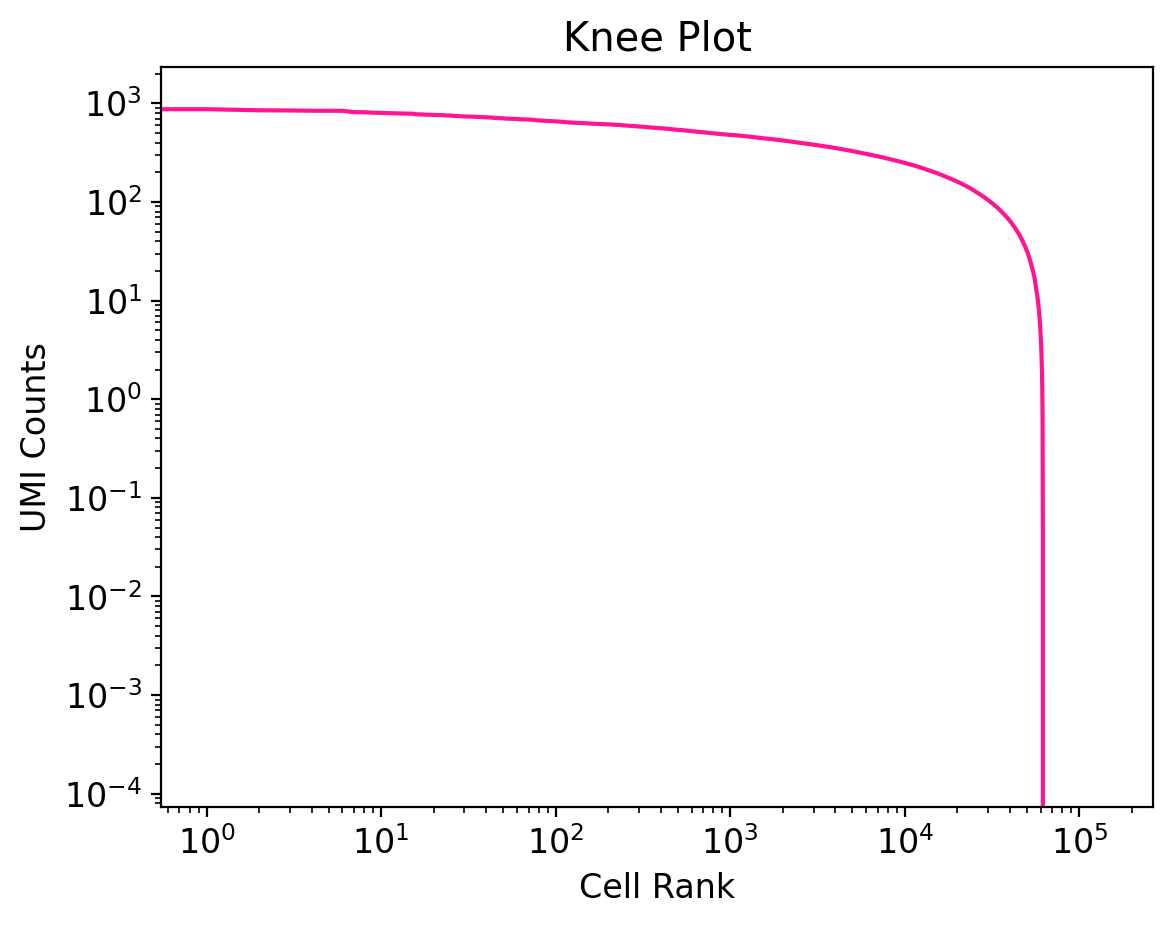

680
146433 cells passed the UMI threshold of 510.9158935546875.


In [8]:
# Calculate the total UMI count per cell to determine UMI cutoff
umis_per_cell = adata.X.sum(axis=1)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(umis_per_cell, bins=50, color="deeppink", edgecolor="black")
plt.title("UMIs per Cell")
plt.xlabel("Number of UMIs")
plt.ylabel("Number of Cells")
plt.show()

# TESTTTTTT Sort UMIs in descending order
sorted_umis = np.sort(umis_per_cell)[::-1]  

plt.loglog(sorted_umis, color="deeppink")
plt.ylabel('UMI Counts')
plt.xlabel('Cell Rank')
plt.title('Knee Plot')
plt.show()

# Identify the knee point programmatically
knee = KneeLocator(range(len(sorted_umis)), sorted_umis, curve='convex', direction='decreasing')
print(knee.knee)  # This will give the rank (or index) of the knee point
knee_umi_threshold = sorted_umis[knee.knee]  # This will give the UMI count at the knee point
print(f"{adata.n_obs} cells passed the UMI threshold of {knee_umi_threshold}.")

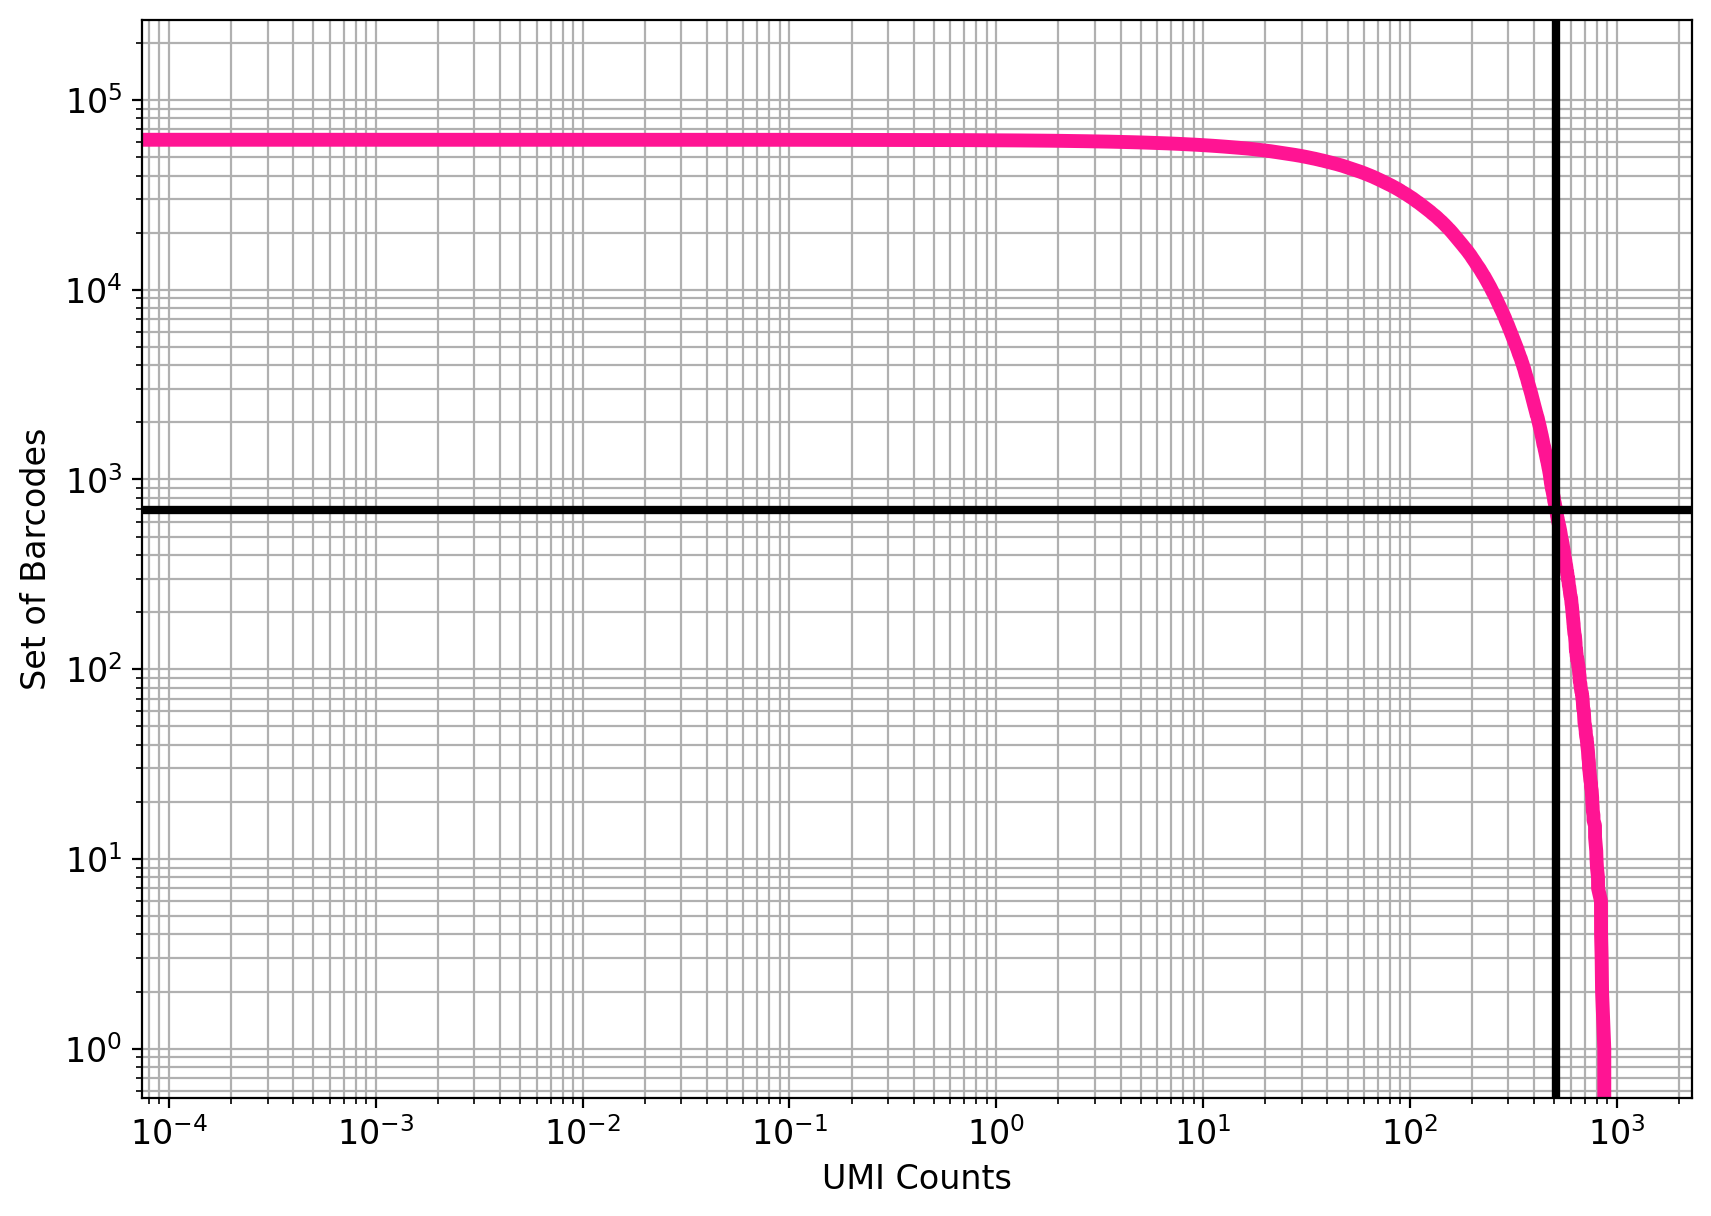

In [9]:
# Running knee plot to find threshold cells according to knee plot { run: "auto", vertical-output: true }

cutoff =  510 #@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="deeppink")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [10]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

688 cells passed the 510 UMI threshold


### Filter empty droplets¶


In [11]:
adata

AnnData object with n_obs × n_vars = 146433 × 1371
    obs: 'X10X_operator', 'Age', 'Cell_culture_batch', 'Cell_state', 'Cell_type', 'Donor', 'Medications', 'Plate', 'Sample_description', 'Sample_id', 'Sex', 'Time_point', 'Well', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'Deconvolution_status', 'cellranger_status', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'S_score', 'G2M_score', 'Phase', 'Activation_level', 'Size_Factor', 'Activation_pseudotime', 'Cell_population', 'Cluster_id'
    var: 'gene_ids', 'feature_types', 'chr', 'start', 'end', 'strand', 'biotype', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_symbols'
    uns: 'Cell_population_colors', 'Cell_state_color

In [12]:
# Filter the cells according to the threshold determined from the knee plot

sc.pp.filter_cells(adata, min_counts=knee[num_cells])

/Users/Sian/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
adata

AnnData object with n_obs × n_vars = 689 × 1371
    obs: 'X10X_operator', 'Age', 'Cell_culture_batch', 'Cell_state', 'Cell_type', 'Donor', 'Medications', 'Plate', 'Sample_description', 'Sample_id', 'Sex', 'Time_point', 'Well', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'Deconvolution_status', 'cellranger_status', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'S_score', 'G2M_score', 'Phase', 'Activation_level', 'Size_Factor', 'Activation_pseudotime', 'Cell_population', 'Cluster_id'
    var: 'gene_ids', 'feature_types', 'chr', 'start', 'end', 'strand', 'biotype', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_symbols'
    uns: 'Cell_population_colors', 'cellranger_status_c

### Filtering out by mitochondrial content

In [14]:
mito_genes = adata.var_names.str.startswith('MT-')


# Helper function to convert potential sparse matrix to numpy array (2D)
def get_2d_array(matrix):
    if hasattr(matrix, "toarray"):
        return matrix.toarray()
    else:
        return matrix


# Compute percent_mito
mito_counts = get_2d_array(adata[:, mito_genes].X.sum(axis=1))
total_counts = get_2d_array(adata.X.sum(axis=1))

adata.obs['percent_mito'] = np.divide(mito_counts, total_counts, out=np.zeros_like(mito_counts), where=total_counts!=0).squeeze()
adata.obs['n_counts'] = total_counts.squeeze()



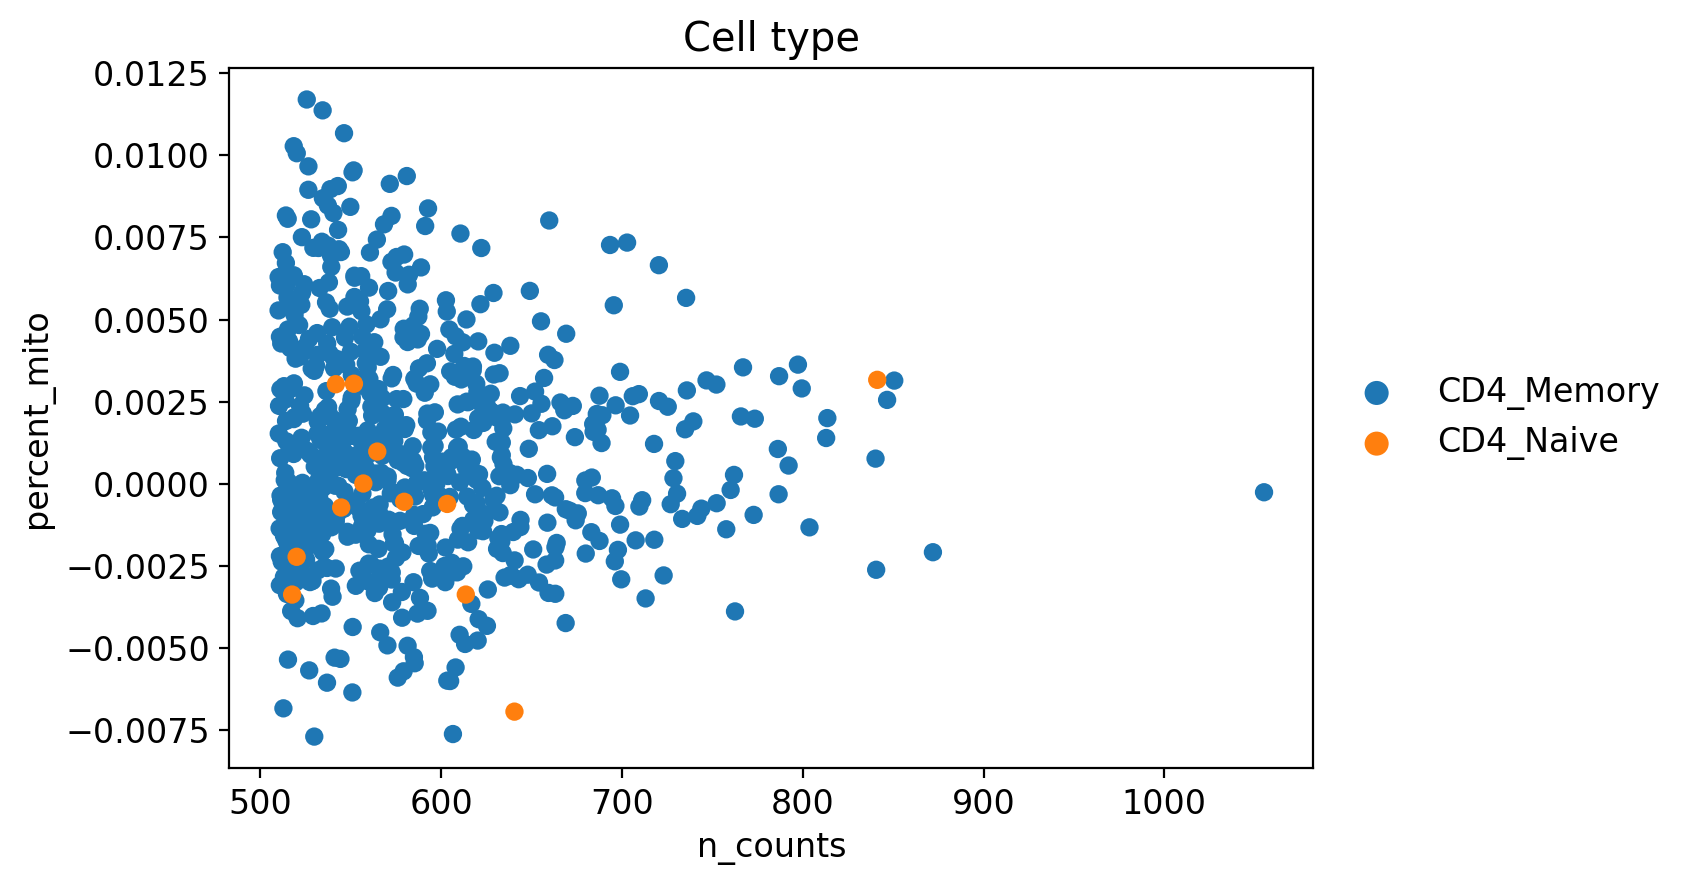

In [15]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color='Cell_type')

### Filter out genes that are not present in any cells¶

In [16]:
sc.pp.filter_genes(adata, min_cells=3)

/Users/Sian/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
adata

AnnData object with n_obs × n_vars = 689 × 1371
    obs: 'X10X_operator', 'Age', 'Cell_culture_batch', 'Cell_state', 'Cell_type', 'Donor', 'Medications', 'Plate', 'Sample_description', 'Sample_id', 'Sex', 'Time_point', 'Well', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'Deconvolution_status', 'cellranger_status', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'S_score', 'G2M_score', 'Phase', 'Activation_level', 'Size_Factor', 'Activation_pseudotime', 'Cell_population', 'Cluster_id'
    var: 'gene_ids', 'feature_types', 'chr', 'start', 'end', 'strand', 'biotype', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_symbols'
    uns: 'Cell_population_colors', 'cellranger_status_c

### Visualizing count distributions¶

## Examination of the gene count and UMI count distributions is useful QC to evaluate the quality of the library and how deeply it was sequenced.

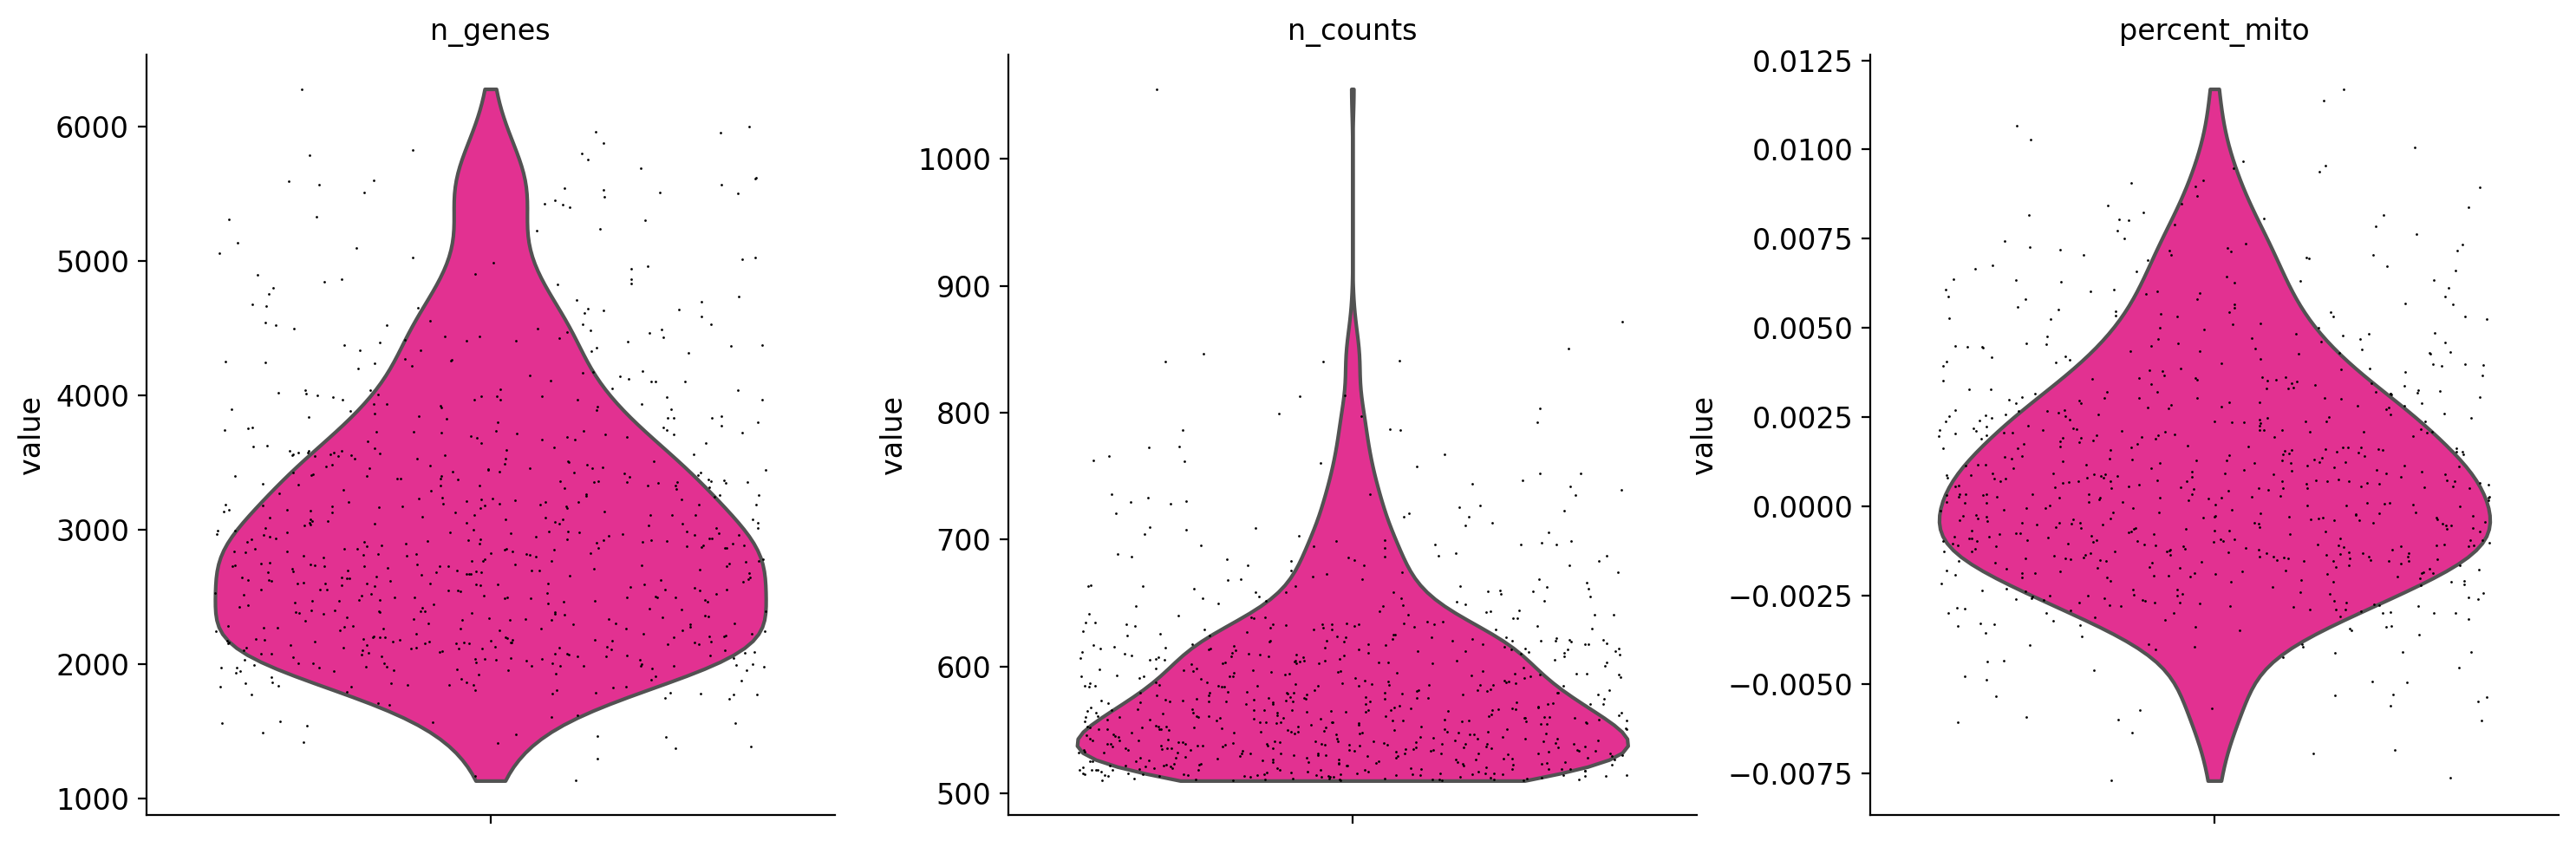

In [18]:
adata.var_names_make_unique()

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, color = 'deeppink')

### Analysis 

##### Normalize and log the data

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/Users/Sian/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


### Identifying highly expressed genes

In [20]:
### The below lines are me trying to get rid of NaN values in data. Not sure if need to run. 

num_nan_data = np.isnan(adata.X).sum()
print(f"Number of NaN values in the data matrix: {num_nan_data}")
num_nan_obs = adata.obs.isnull().sum().sum()
print(f"Number of NaN values in the .obs dataframe: {num_nan_obs}")

num_nan_var = adata.var.isnull().sum().sum()
print(f"Number of NaN values in the .var dataframe: {num_nan_var}")
total_nan = num_nan_data + num_nan_obs + num_nan_var
print(f"Total number of NaN values in adata: {total_nan}")

adata.X = np.nan_to_num(adata.X)
adata.obs = adata.obs.fillna("Unknown")


Number of NaN values in the data matrix: 619002
Number of NaN values in the .obs dataframe: 28
Number of NaN values in the .var dataframe: 0
Total number of NaN values in adata: 619030


In [21]:
# found top expressed genes, not most variably expressed

gene_mean = np.nanmean(adata.X, axis=0)  # Compute mean expression for each gene, avoiding NaNs
gene_names = adata.var_names  # Retrieve gene names

# Create a pandas Series for easier sorting and retrieval of top genes
gene_expression = pd.Series(gene_mean, index=gene_names)
highest_expressed_genes = gene_expression.sort_values(ascending=False)

# Display top N genes (e.g., top 20)
print(highest_expressed_genes.head(20))


gene_symbols
LGALS1      3.064543
S100A4      3.027275
LSP1        2.941577
IL2RG       2.910776
OPTN        2.902218
ANXA2       2.894194
S100A6      2.857456
STING1      2.844293
NEAT1       2.797309
CYBA        2.786896
ARID5A      2.778708
IL2RA       2.772532
BATF        2.760073
S100A10     2.743892
MYO1G       2.738437
APOBEC3G    2.693757
FAS         2.686487
NFKBIA      2.674825
LGALS3      2.669994
TMEM59      2.628880
dtype: float32


### Identifying highly variable genes

/Users/Sian/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/Users/Sian/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:269: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(


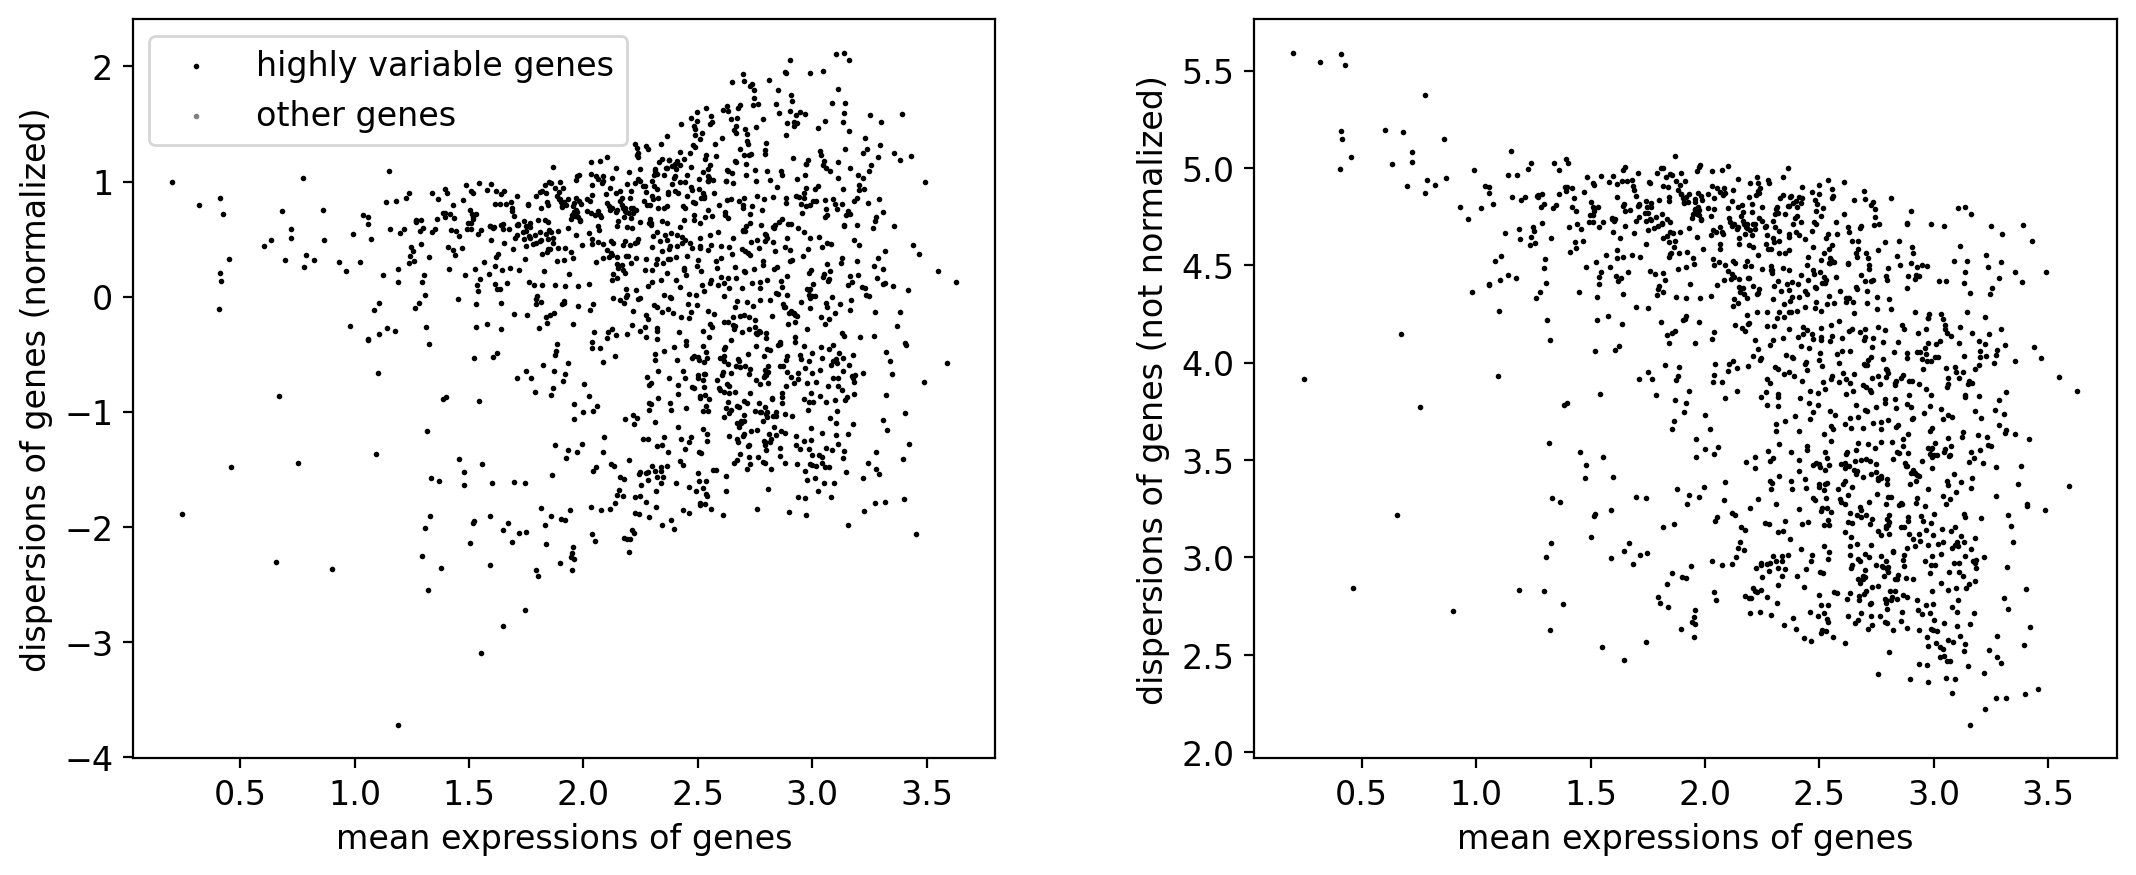

In [22]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)



In [23]:
sc.pp.scale(adata, max_value=10)

### Clustering and visualization

In [24]:
# Cluster the cells using Louvain clustering
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata)

### PCA

/Users/Sian/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


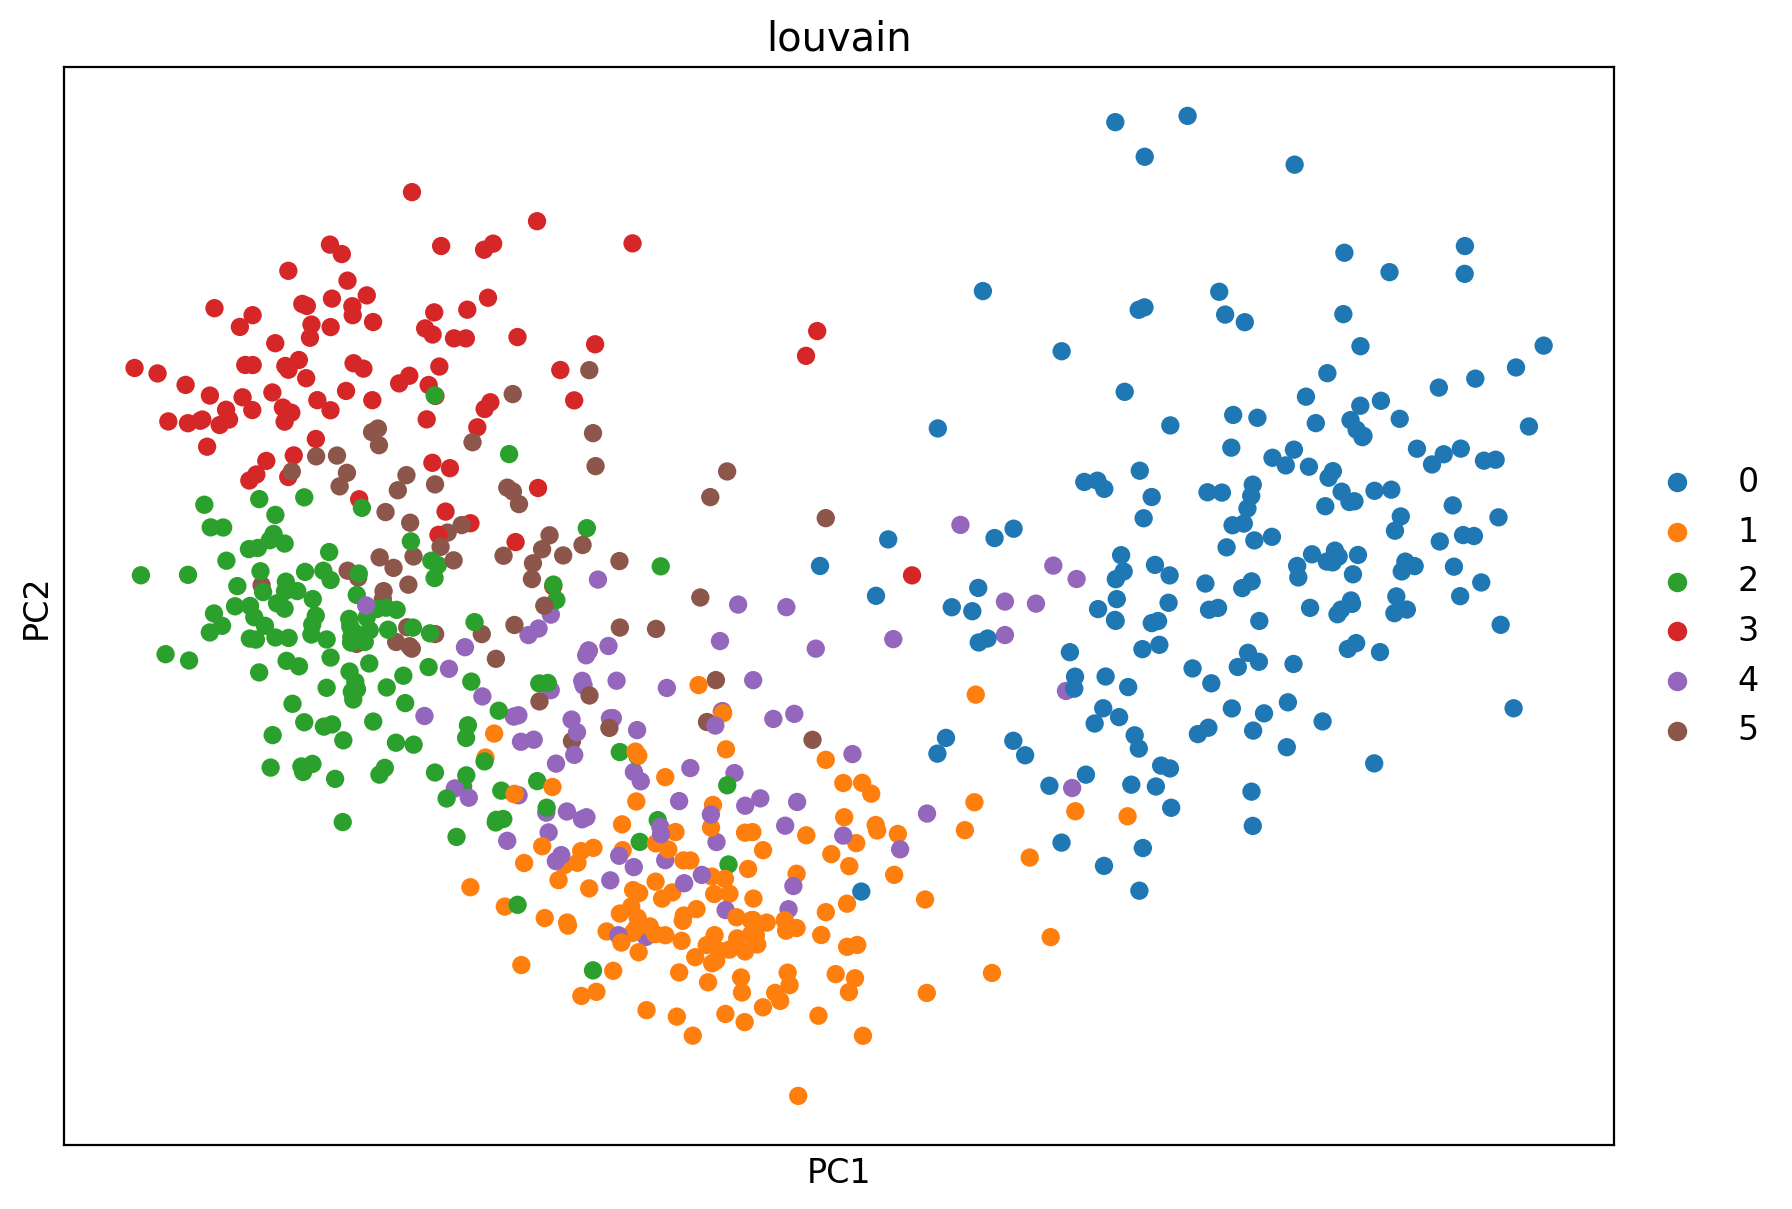

In [25]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)


### tSNE

In [26]:
# Visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to 
# performing t-SNE
sc.tl.tsne(adata, n_pcs=10)

/Users/Sian/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


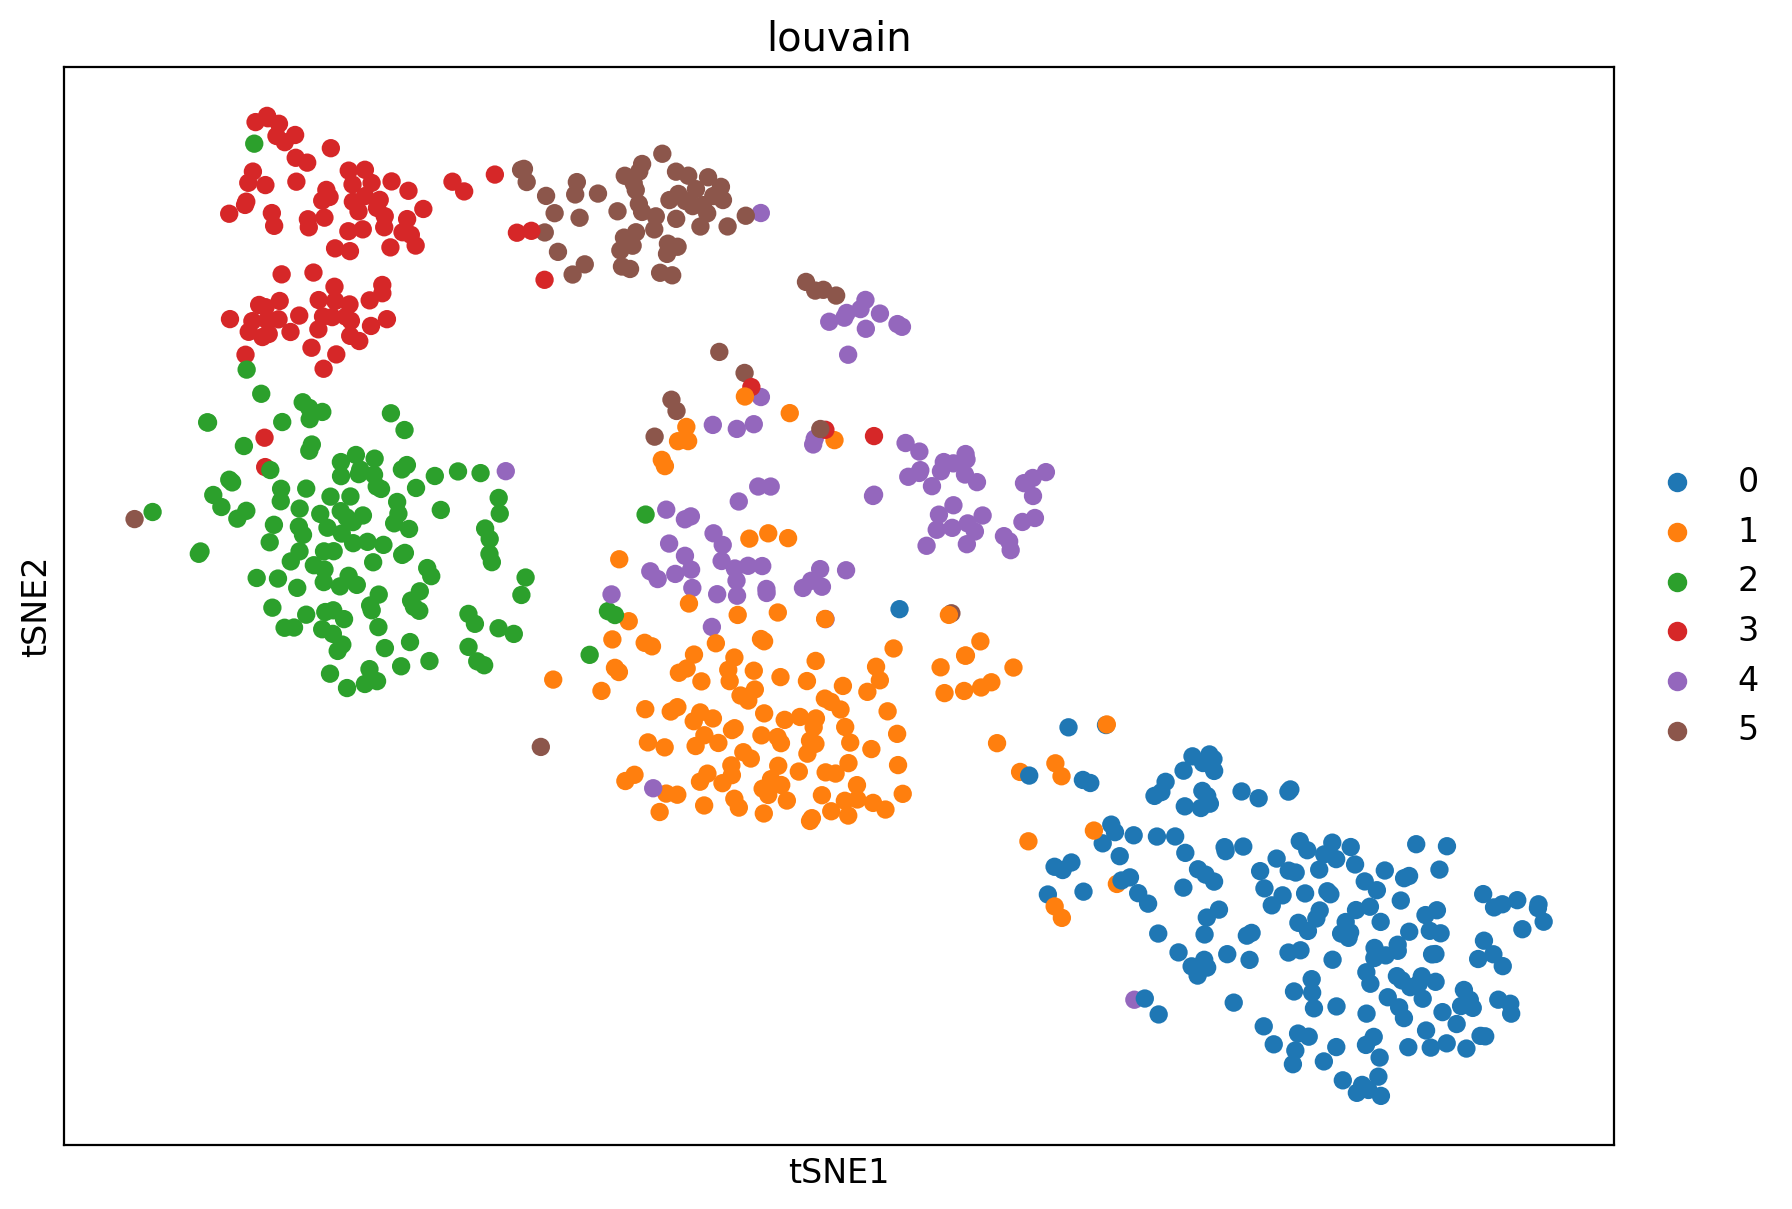

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

### UMAP

In [28]:
# Visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to 
# performing t-SNE
sc.tl.umap(adata)

/Users/Sian/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


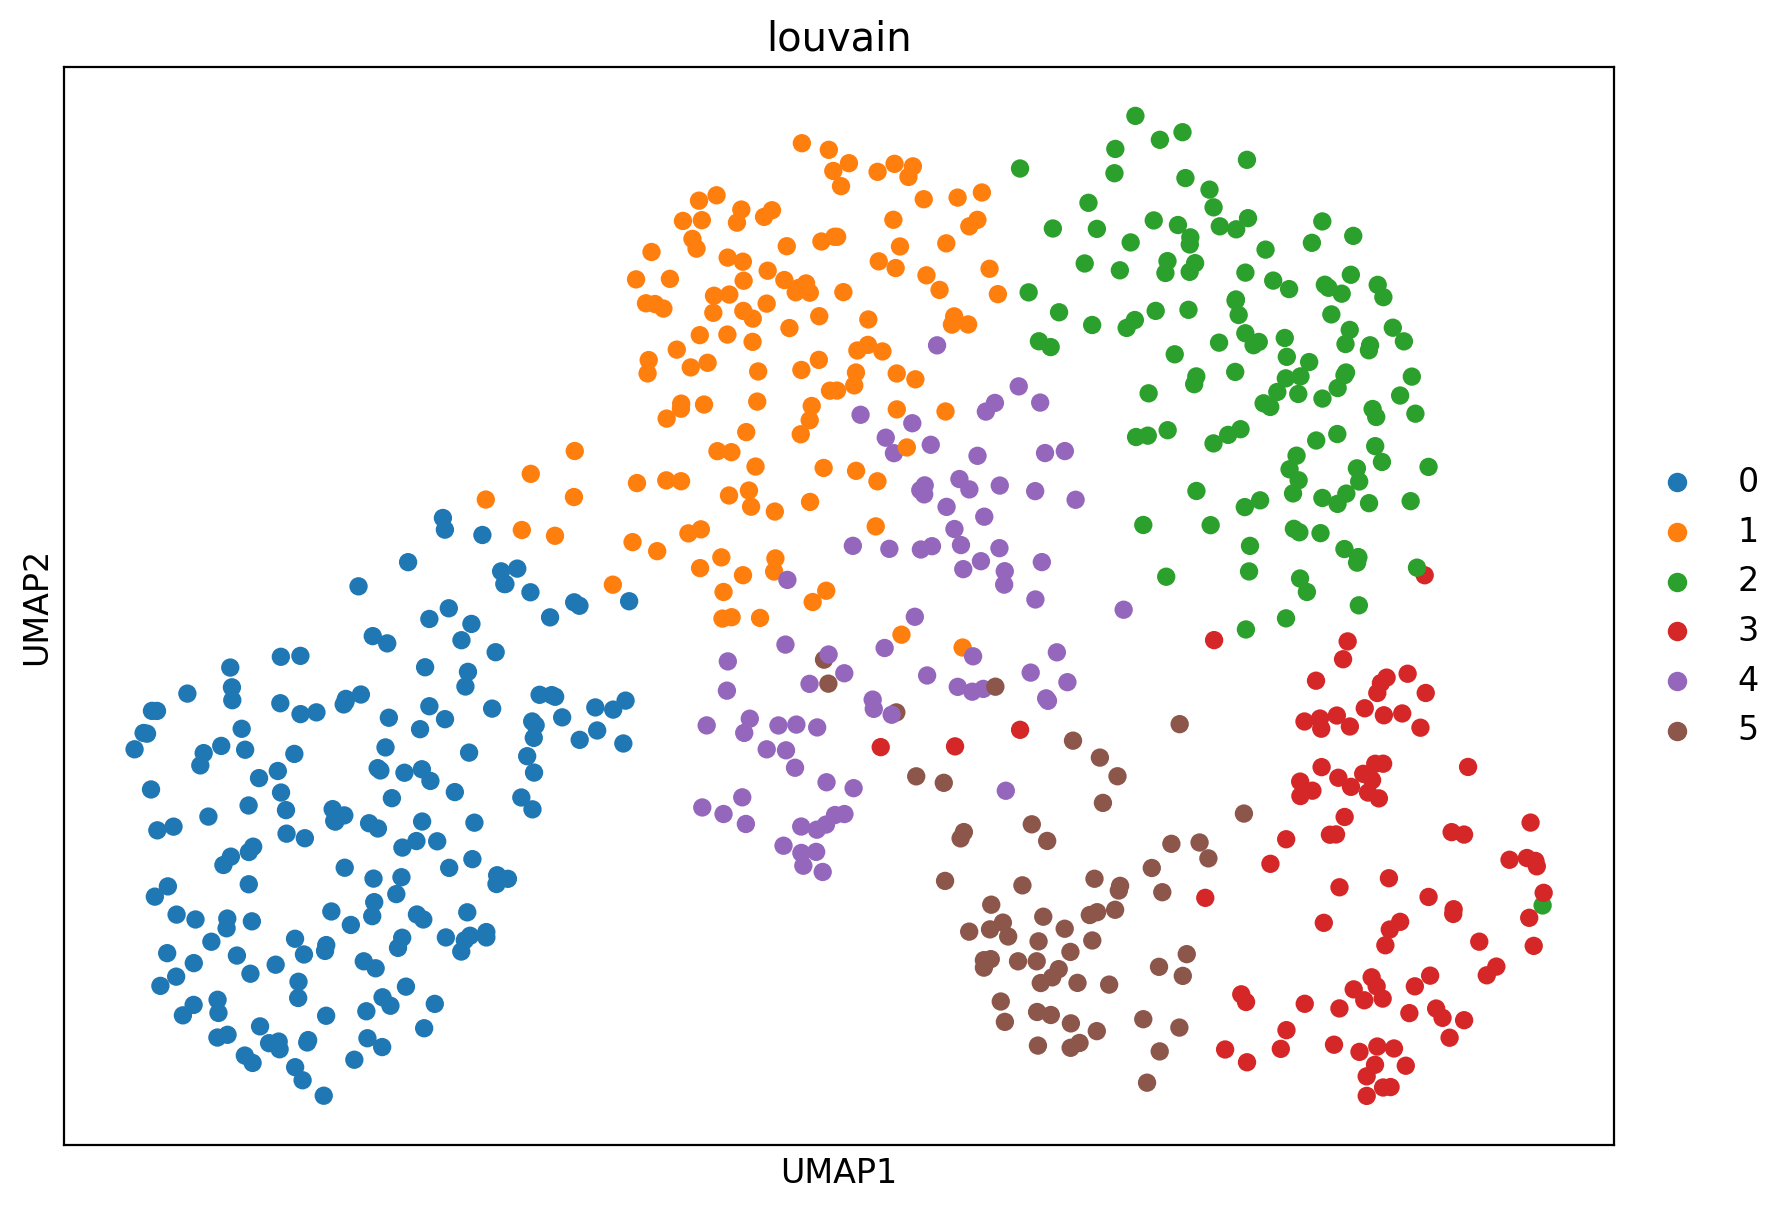

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

### Variance explained by each component

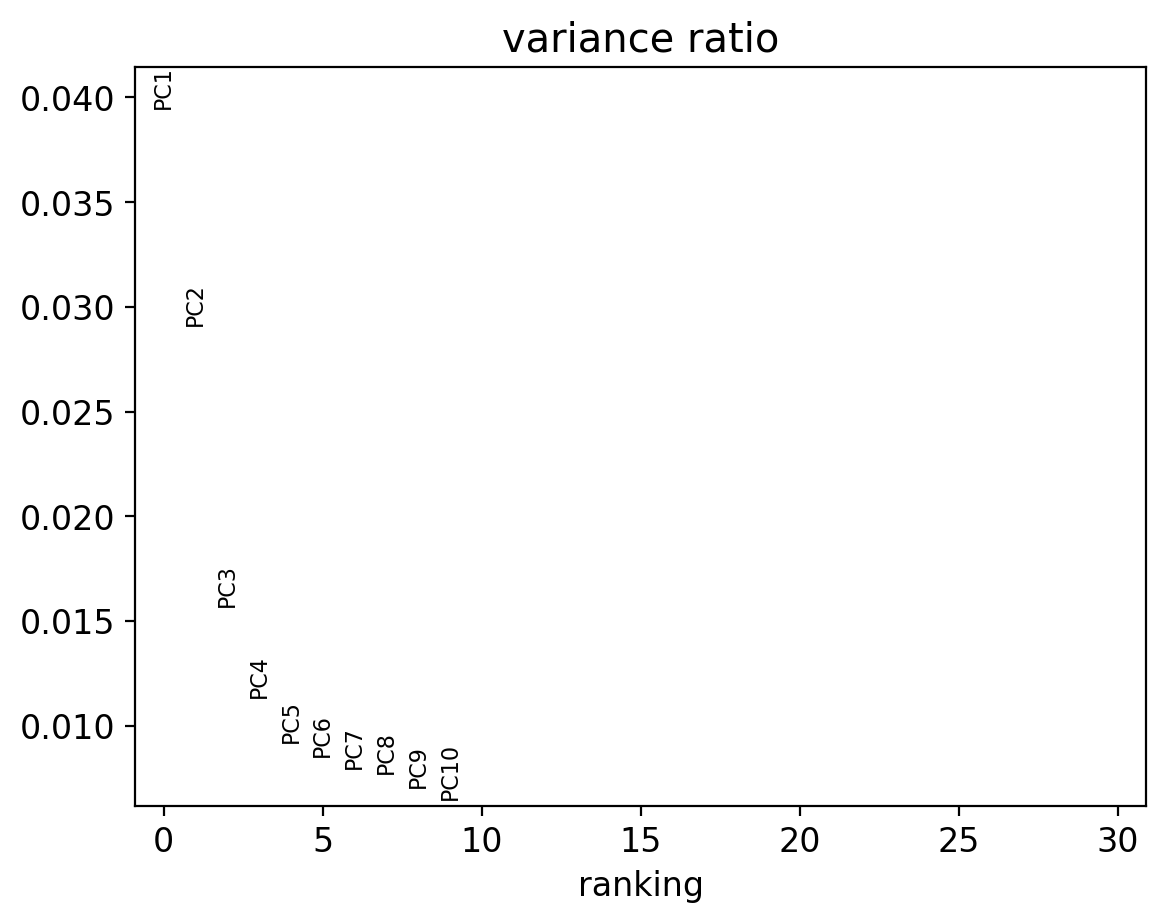

In [30]:
# Compute and plot the variance explained by the PC subspaces.
sc.pl.pca_variance_ratio(adata)